# Librerias

In [ ]:
!pip install keras_vggface
!pip install keras_applications
!pip install tensorflow keras

In [ ]:
import pickle 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import tensorflow as tf
import keras
from keras_vggface.vggface import VGGFace
from google.colab import drive
from pathlib import Path
from datetime import datetime
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Importamos la data

In [ ]:
drive.mount('/content/gdrive')

In [ ]:
data=pd.read_csv("/content/gdrive/MyDrive/fer2013.csv")
data.emotion.value_counts()

In [ ]:
FER2013_WIDTH = 48
FER2013_HEIGHT = 48

In [ ]:
Emotions = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# Ejemplo de imagen

Samuel Jackson enojado
Angry


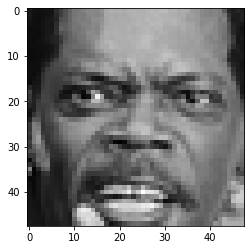

In [ ]:
num=10
array = np.mat(data.pixels[num]).reshape(48, 48,1)
print("Samuel Jackson enojado")
plt.imshow(array, cmap='gray')#, cmap=plt.cm.binary)
print(Emotions[data.emotion[num]])

# Preprocesamiento

In [ ]:
# Separamos training y public/private testing data
valid_data = data[data.Usage=="PublicTest"].reset_index(drop=True)
test_data = data[data.Usage=="PrivateTest"].reset_index(drop=True)
train_data = data[data.Usage=="Training"].reset_index(drop=True)

In [ ]:
print("Train")
print(train_data.emotion.value_counts())
print("Valid")
print(valid_data.emotion.value_counts())
print("Test")
print(test_data.emotion.value_counts())

In [ ]:
def fer2013_to_X(data,enr):
    pixels_list = data["pixels"].values
    labels_list = data["emotion"].values
    count=0
    for pixels in pixels_list:
      
        #normal data
        single_image = np.reshape(pixels.split(" "), (FER2013_WIDTH, FER2013_HEIGHT)).astype("float")
        im = Image.fromarray((single_image).astype(np.uint8))
        sink = Path(f"data/{enr}/{Emotions[labels_list[count]]}")
        if not sink.exists():
          sink.mkdir(parents=True, exist_ok=True)
        im.save(f"data/{enr}/{Emotions[labels_list[count]]}/FER2013-{enr}-{Emotions[labels_list[count]]}-{count}.png")
                
        count=count+1

In [ ]:
# Crear directorios
fer2013_to_X(train_data,"train")
fer2013_to_X(valid_data,"valid")
fer2013_to_X(test_data,"test")

# Modelos

In [ ]:
xy_training = tf.keras.preprocessing.image_dataset_from_directory("/content/data/train", image_size=(48,48), color_mode='grayscale',label_mode="int")
xy_validation = tf.keras.preprocessing.image_dataset_from_directory("/content/data/valid", image_size=(48,48), color_mode='grayscale',label_mode="int")
xy_testing = tf.keras.preprocessing.image_dataset_from_directory("/content/data/test", image_size=(48,48), color_mode='grayscale',label_mode="int")

## Regresion logistical multinomial

In [ ]:
x_train=[]
y_train=[]
for x, y in xy_training:
  for im in list(np.array(x)):
    x_train=x_train+[np.array(im)]#a)]
  y_train=y_train+list(np.array(y))

x_train=np.array(x_train).reshape(len(x_train),48*48*1)
y_train=np.array(y_train)

In [ ]:
pipe = make_pipeline(StandardScaler(), LogisticRegression(multi_class='multinomial', fit_intercept=True,max_iter=10000))
pipe.fit(x_train, y_train) 

In [ ]:
x_test=[]
y_test=[]
for x, y in xy_testing:
  for im in list(np.array(x)):
    x_test=x_test+[np.array(im)]#a)]
  y_test=y_test+list(np.array(y))

x_test=np.array(x_test).reshape(len(x_test),48*48*1)
y_test=np.array(y_test)

In [ ]:
pred=pipe.predict(x_test)
true=y_test
np.mean(pred==true)

In [ ]:
filename = 'ML_finalized_model.sav'
pickle.dump(pipe, open(filename, 'wb'))

In [ ]:
from google.colab import files

files.download('ML_finalized_model.sav')

## "Regresión Logística" con softmax

In [ ]:
model_l = keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(48,48, 1)),
    keras.layers.Lambda(lambda x: x/255.0),                 
    keras.layers.Flatten(),
    keras.layers.Dense(7, activation='softmax')
])
model_l.summary()

In [ ]:
model_l.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_l.fit(xy_training, validation_data=xy_validation, epochs=50)

In [ ]:
test_loss, test_acc = model_l.evaluate(xy_testing, verbose=2)
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
model_l.save(f"ML{timestamp}.h5")

In [ ]:
test_loss, test_acc

In [ ]:
from google.colab import files

files.download(f"ML{timestamp}.h5")

## Redes FC


In [ ]:
model_fc = keras.Sequential([
    keras.layers.InputLayer(input_shape=(48,48, 1)),
    keras.layers.Lambda(lambda x: x/255.0),
    keras.layers.Flatten(),
    keras.layers.Dense(288, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(7, activation='softmax')
])
model_fc.summary()

In [ ]:
model_fc.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_fc.fit(xy_training, validation_data=xy_validation, epochs=5)

In [ ]:
test_loss, test_acc = model_fc.evaluate(xy_testing, verbose=2)
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
model_fc.save(f"FF{timestamp}-con-division.h5")

In [ ]:
from google.colab import files

files.download(f"FF{timestamp}-con-division.h5")

## Redes CNN

In [ ]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(48,48, 1)),
    keras.layers.Lambda(lambda x: x/255.0),

    keras.layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
          
    keras.layers.Conv2D(256, (3, 3), activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(256, (3, 3), activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),

    keras.layers.Flatten(),
    keras.layers.Dense(7, activation='softmax')
])
model.summary()


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.fit(xy_training, validation_data=xy_validation, epochs=50)

In [ ]:
test_loss, test_acc = model.evaluate(xy_testing, verbose=2)
test_loss, test_acc
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
model.save(f"CNN2{timestamp}.h5")

In [ ]:
from google.colab import files

files.download(f"CNN2{timestamp}.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## TL: **VGG Face**

Inspiracion:

https://github.com/ivadym/FER

https://github.com/rcmalli/keras-vggface

Performa cerca del 71% (ganador de la competencia)

In [ ]:
img_height, img_width = 224,224#197, 197#
module=VGGFace(model = 'resnet50',include_top = False,weights = 'vggface',input_shape = (img_height, img_width, 3))

In [ ]:
xy_training = tf.keras.preprocessing.image_dataset_from_directory("/content/data/train", image_size=(img_height, img_width), color_mode='rgb',label_mode="int")
xy_validation = tf.keras.preprocessing.image_dataset_from_directory("/content/data/valid", image_size=(img_height, img_width), color_mode='rgb',label_mode="int")
xy_testing = tf.keras.preprocessing.image_dataset_from_directory("/content/data/test", image_size=(img_height, img_width), color_mode='rgb',label_mode="int")

In [ ]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
    keras.layers.Lambda(lambda x: (x-128.8006)), 
    module,
    keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2, 2),padding="same"),
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation="relu"),
    keras.layers.Dense(7, "sigmoid"), 
])

model.summary()

In [ ]:
model.compile(
    optimizer   = tf.keras.optimizers.SGD(lr = 1e-4, momentum = 0.9, decay = 0.0, nesterov = True),
    loss        = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics     = ['accuracy'])

In [ ]:
earlystop = tf.keras.callbacks.EarlyStopping("val_loss", 0.01, 9, restore_best_weights=True)
model.fit(xy_training, validation_data=xy_validation, epochs=10)#, callbacks=[earlystop])
test_loss, test_acc = model.evaluate(xy_testing, verbose=2)

In [ ]:
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
model.save(f"VGGface{timestamp}.h5")

In [ ]:
test_loss, test_acc = model.evaluate(xy_testing, verbose=2)
test_loss, test_acc

In [ ]:
from google.colab import files

files.download(f"VGGface{timestamp}.h5")